<a href="https://colab.research.google.com/github/XingxinHE/Chief_Curator_Griffin/blob/master/03_Griffin_Try_to_distinguish_the_material_of_art.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')
import os, shutil
os.chdir("/content/gdrive/My Drive/Kaggle/Rijksmuseum")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np

In [22]:
ls

'01#Loading Info From XML'
'02#Discover Interesting Data'
'03#Griffin Try to distinguish the material of art'
'03#Griffin Try to distinguish the type of art_batch'
'04#Griffin_distinguish the period of art'
 05_Spectrum_of_Art.ipynb
 100k_images_features.p
 date_df.csv
 date_type.csv
'[FAIL & ANALYSIS] 03#Griffin Try to distinguish the type of art'
 full_pca_features.p
 gan_img.csv
 griffin_guess_mtl_training.csv
 jpg/
 material_df.csv
 material_df_multlclass_singlelabel_average_amounts.csv
 material_single_label_df.csv
 oil_painting_df.csv
 peroid_df_for_training.csv
 project_curator.csv
 Rembrandt
 type_df.csv
 xml/


## Import the csv

In [24]:
df = pd.read_csv('material_df_binary_oil_recognition.csv', index_col=0)

In [25]:
df

,tag,olieverf
0,0000002_SK-A-4877.jpg,1
1,0000003_SK-A-4881.jpg,1
2,0000098_RP-T-1963-86.jpg,0
3,0000100_RP-T-1961-18.jpg,0
4,0000125_RP-T-1964-173.jpg,0
...,...,...
4043,0111100_RP-T-00-411.jpg,0
4044,0111580_RP-T-2011-76.jpg,1
4045,0112118_BK-2011-31.jpg,1
4046,0112132_NG-C-2011-2.jpg,1


## Set Up

In [26]:
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
import keras

## Input X: Load Image

In [27]:
columns=df.columns[1]
columns

'olieverf'

In [28]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [29]:
total_len_dataset = len(df.index)
train_prop = 0.7
val_prop = 0.25
test_prop = train_prop - val_prop

train_last_idx = int(np.floor(total_len_dataset*train_prop))
val_last_idx = int(np.floor(total_len_dataset*val_prop)) + train_last_idx
test_first_idx = val_last_idx

print(train_last_idx, val_last_idx, test_first_idx)

2833 3845 3845


In [30]:
train_generator=datagen.flow_from_dataframe(
dataframe=df[:train_last_idx],
directory="/content/gdrive/My Drive/Kaggle/Rijksmuseum/jpg",
x_col="tag",
y_col=columns,
batch_size=32,
seed=23,
shuffle=True,
class_mode="raw",
target_size=(256,256))

Found 2833 validated image filenames.


In [31]:
valid_generator=test_datagen.flow_from_dataframe(
dataframe=df[train_last_idx:val_last_idx],
directory="/content/gdrive/My Drive/Kaggle/Rijksmuseum/jpg",
x_col="tag",
y_col=columns,
batch_size=32,
seed=23,
shuffle=True,
class_mode="raw",
target_size=(256,256))

Found 1012 validated image filenames.


In [32]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=df[test_first_idx:],
directory="/content/gdrive/My Drive/Kaggle/Rijksmuseum/jpg",
x_col="tag",
batch_size=1,
seed=32,
shuffle=False,
class_mode=None,
target_size=(256,256))

Found 203 validated image filenames.


## Build the model

In [33]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(256,256,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

## Training Model

In [40]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

Epoch 1/3
88/88 [==============================] - 1077s 12s/step - loss: 0.1316 - accuracy: 0.9543 - val_loss: 0.1924 - val_accuracy: 0.9950
Epoch 2/3
88/88 [==============================] - 1072s 12s/step - loss: 0.1123 - accuracy: 0.9618 - val_loss: 0.3033 - val_accuracy: 0.9849
Epoch 3/3
88/88 [==============================] - 1062s 12s/step - loss: 0.1071 - accuracy: 0.9636 - val_loss: 0.2818 - val_accuracy: 0.9748


In [70]:
model.save('griffin_guess_material_oil_binary.h5')

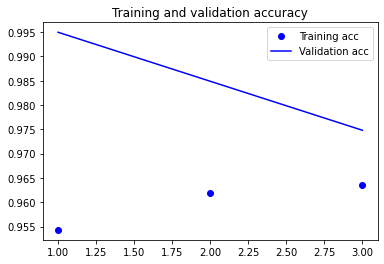

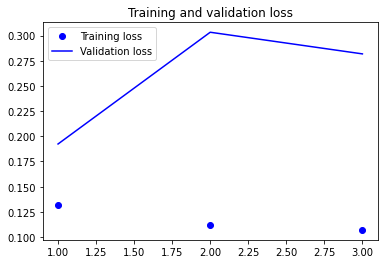

In [44]:
import matplotlib.pyplot as plt
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.legend()
plt.show()

## Prediction

In [45]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

203/203 [==============================] - 48s 238ms/step


In [46]:
pred

array([[0.2070924 ],
       [0.23245946],
       [0.2213606 ],
       [0.24847963],
       [0.25050697],
       [0.25295967],
       [0.22298324],
       [0.2594207 ],
       [0.23543853],
       [0.25361738],
       [0.25674355],
       [0.27205896],
       [0.2634836 ],
       [0.21989742],
       [0.28247458],
       [0.2631206 ],
       [0.2768339 ],
       [0.25993878],
       [0.26780912],
       [0.25993925],
       [0.28797394],
       [0.25845462],
       [0.2789188 ],
       [0.25420266],
       [0.2650433 ],
       [0.2621507 ],
       [0.14290884],
       [0.25577903],
       [0.16304064],
       [0.11660817],
       [0.10484731],
       [0.24546617],
       [0.20123959],
       [0.24238995],
       [0.1914801 ],
       [0.23869526],
       [0.23868391],
       [0.2012142 ],
       [0.38500255],
       [0.15502274],
       [0.25999686],
       [0.30082473],
       [0.2031798 ],
       [0.20123348],
       [0.37908232],
       [0.2787836 ],
       [0.21108359],
       [0.161

In [47]:
pred_bool = (pred >0.5)
pred_bool

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [

In [60]:
predictions = pred_bool.astype(int)

results=pd.DataFrame(predictions, columns=['Predict'])
results["Files Name"]=test_generator.filenames
results

,Predict,Files Name
0,0,0107843_BI-1887-1463-168(R).jpg
1,0,0107844_BI-1887-1463-168(V).jpg
2,0,0107845_BI-1887-1463-169(R).jpg
3,0,0107846_BI-1887-1463-169(V).jpg
4,0,0107848_BI-1887-1463-170(R).jpg
...,...,...
198,0,0111100_RP-T-00-411.jpg
199,1,0111580_RP-T-2011-76.jpg
200,1,0112118_BK-2011-31.jpg
201,1,0112132_NG-C-2011-2.jpg


In [61]:
df.iloc[test_first_idx:]

,tag,olieverf
3845,0107843_BI-1887-1463-168(R).jpg,0
3846,0107844_BI-1887-1463-168(V).jpg,0
3847,0107845_BI-1887-1463-169(R).jpg,0
3848,0107846_BI-1887-1463-169(V).jpg,0
3849,0107848_BI-1887-1463-170(R).jpg,0
...,...,...
4043,0111100_RP-T-00-411.jpg,0
4044,0111580_RP-T-2011-76.jpg,1
4045,0112118_BK-2011-31.jpg,1
4046,0112132_NG-C-2011-2.jpg,1


In [62]:
true_df = df.iloc[test_first_idx:]
true_df.reset_index(drop=True, inplace=True)
true_df

,tag,olieverf
0,0107843_BI-1887-1463-168(R).jpg,0
1,0107844_BI-1887-1463-168(V).jpg,0
2,0107845_BI-1887-1463-169(R).jpg,0
3,0107846_BI-1887-1463-169(V).jpg,0
4,0107848_BI-1887-1463-170(R).jpg,0
...,...,...
198,0111100_RP-T-00-411.jpg,0
199,0111580_RP-T-2011-76.jpg,1
200,0112118_BK-2011-31.jpg,1
201,0112132_NG-C-2011-2.jpg,1


In [63]:
results['True'] = true_df['olieverf']
results

,Predict,Files Name,True
0,0,0107843_BI-1887-1463-168(R).jpg,0
1,0,0107844_BI-1887-1463-168(V).jpg,0
2,0,0107845_BI-1887-1463-169(R).jpg,0
3,0,0107846_BI-1887-1463-169(V).jpg,0
4,0,0107848_BI-1887-1463-170(R).jpg,0
...,...,...,...
198,0,0111100_RP-T-00-411.jpg,0
199,1,0111580_RP-T-2011-76.jpg,1
200,1,0112118_BK-2011-31.jpg,1
201,1,0112132_NG-C-2011-2.jpg,1


In [65]:
col = ['Files Name', 'True', 'Predict']
results = results[col]
results

,Files Name,True,Predict
0,0107843_BI-1887-1463-168(R).jpg,0,0
1,0107844_BI-1887-1463-168(V).jpg,0,0
2,0107845_BI-1887-1463-169(R).jpg,0,0
3,0107846_BI-1887-1463-169(V).jpg,0,0
4,0107848_BI-1887-1463-170(R).jpg,0,0
...,...,...,...
198,0111100_RP-T-00-411.jpg,0,0
199,0111580_RP-T-2011-76.jpg,1,1
200,0112118_BK-2011-31.jpg,1,1
201,0112132_NG-C-2011-2.jpg,1,1


In [68]:
accuracy = len(results[results['True']==results['Predict']].index) / len(results.index)

In [69]:
accuracy

0.9852216748768473

In [71]:
results.to_csv('guess_mtl_oil_binary.csv')